In [13]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K # for tensor/matrix op
from keras import metrics

#define const
batch_size = 100 #B 
input_dim = 784 #D 
latent_dim = 2 #K, gaussian dim
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [14]:
x = Input(batch_shape = (batch_size, input_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [15]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean = 0.0,
                stddev = epsilon_std)
    return z_mean + K.exp(z_log_sigma / 2) * epsilon # why log variance / 2

In [17]:
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [23]:
vae = Model(x, x_decoded_mean)

#the copy-and-paste-no-clue-what's-going-on part
def vae_loss(x, x_decoded_mean):
    xent_loss = input_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

encoder = Model(x, z_mean)

In [35]:
K.mean(z_log_sigma, axis=1).shape

TensorShape([Dimension(100)])

In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s - loss: 191.0018 - val_loss: 182.7357
Epoch 2/10
60000/60000 [==============================] - 15s - loss: 176.0781 - val_loss: 171.4121
Epoch 3/10
60000/60000 [==============================] - 15s - loss: 170.2568 - val_loss: 168.5959
Epoch 4/10
60000/60000 [==============================] - 16s - loss: 168.5996 - val_loss: 167.5037
Epoch 5/10
60000/60000 [==============================] - 16s - loss: 167.5713 - val_loss: 167.2534
Epoch 6/10
60000/60000 [==============================] - 16s - loss: 166.9567 - val_loss: 166.7546
Epoch 7/10
60000/60000 [==============================] - 16s - loss: 166.2717 - val_loss: 165.8709
Epoch 8/10
60000/60000 [==============================] - 17s - loss: 166.0334 - val_loss: 168.5387
Epoch 9/10
60000/60000 [==============================] - 16s - loss: 165.7785 - val_loss: 165.7166
Epoch 10/10
60000/60000 [=========================

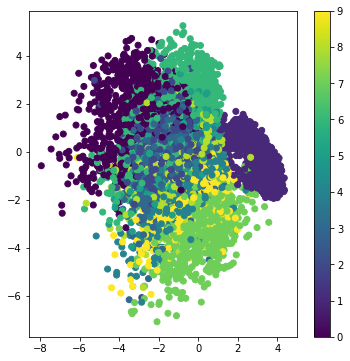

In [25]:


x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


In [26]:

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


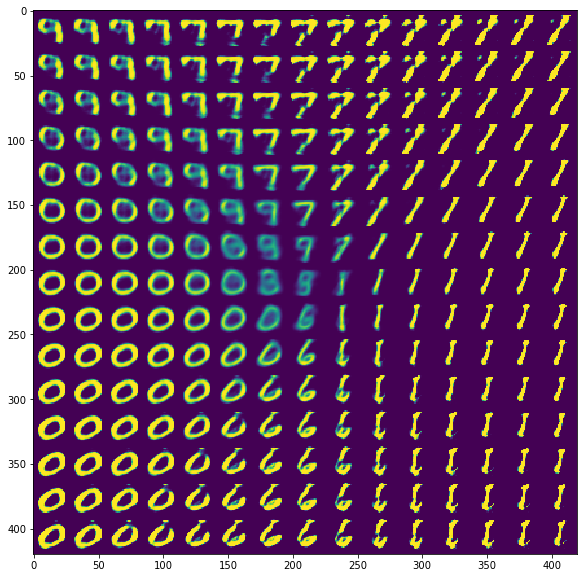

In [27]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()